In [1]:
# project root를 sys.path에 추가
import os, sys
parent_dir = os.path.dirname(os.path.abspath(''))
if not parent_dir in sys.path: 
    sys.path.append(parent_dir)

In [2]:
# plot관련
import torch
from typing import List
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

In [3]:
import numpy as np
import pathlib
from src.utils import get_filenames_of_path
from src.transformations import Clip, ComposeDouble
from src.transformations import FunctionWrapperDouble
from src.transformations import normalize_01

from src.dataset import FaceDataset

In [4]:
def show(imgs: List[torch.Tensor]):
    """
    tensor list를 plt으로 한row로 그린다.    
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [5]:
# root directory
root = pathlib.Path('../data/heads')

In [6]:
# input and target files
inputs = get_filenames_of_path(root / 'input')
targets = get_filenames_of_path(root / 'target')

inputs.sort()
targets.sort()
print(inputs[0])
print(targets[0])

../data/heads/input/000.jpg
../data/heads/target/000.json


In [7]:
mapping = {
    'head': 1,
}

In [8]:
transforms = ComposeDouble([
    Clip(),
    # AlbumentationWrapper(albumentation=A.HorizontalFlip(p=0.5)),
    # AlbumentationWrapper(albumentation=A.RandomScale(p=0.5, scale_limit=0.5)),
    # AlbumentationWrapper(albumentation=A.VerticalFlip(p=0.5)),
    FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

In [9]:
dataset = FaceDataset(inputs=inputs,
                                 targets=targets,
                                 transform=transforms,
                                 use_cache=False,
                                 convert_to_format=None,
                                 mapping=mapping)
print(len(dataset))

20


In [10]:
dict = dataset[0]
print(dict.keys())
print(dict['x'].shape, dict['x'].dtype)
print(dict['y'].keys())
print(dict['y']['boxes'].shape)
print(dict['x_name'])
print(dict['y_name'])

dict_keys(['x', 'y', 'x_name', 'y_name'])
torch.Size([3, 1000, 1000]) torch.float32
dict_keys(['boxes', 'labels'])
torch.Size([25, 4])
000.jpg
000.json


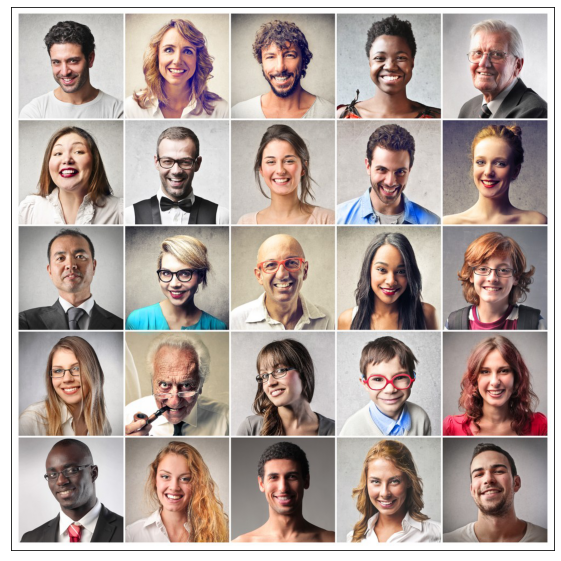

In [11]:
show([dict['x']])

In [12]:
img = (dict['x']*256).to(dtype=torch.uint8)

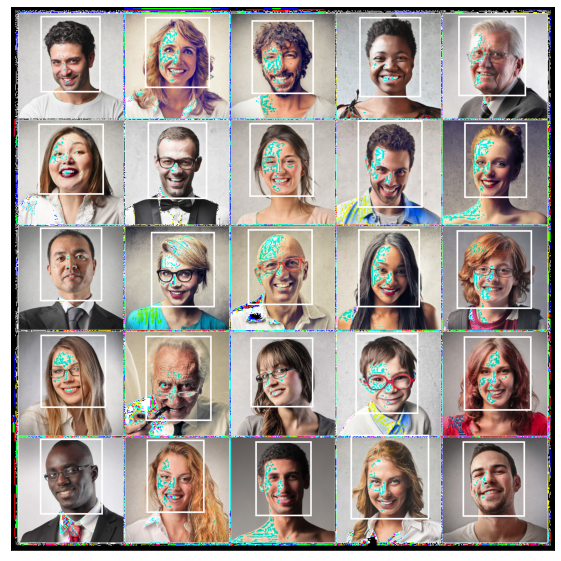

In [13]:
show(draw_bounding_boxes(img, dict['y']['boxes'], width=3))

In [14]:
def collate_double(batch):
    """
    collate function for the ObjectDetectionDataSet.
    Only used by the dataloader.
    """
    x = [sample['x'] for sample in batch]
    y = [sample['y'] for sample in batch]
    x_name = [sample['x_name'] for sample in batch]
    y_name = [sample['y_name'] for sample in batch]
    return x, y, x_name, y_name


from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=dataset,
                        batch_size=2,
                        shuffle=False,
                        num_workers=0,
                        collate_fn=collate_double)

In [15]:
batch = next(iter(dataloader))

In [16]:
(x, y, _, _) = batch
assert len(x) == 2
print(x[0].shape, x[0].dtype)
print(x[1].shape, x[1].dtype)

torch.Size([3, 1000, 1000]) torch.float32
torch.Size([3, 710, 1024]) torch.float32


In [18]:
from src.utils import stats_dataset

stats = stats_dataset(dataset)

from torchvision.models.detection.transform import GeneralizedRCNNTransform

transform = GeneralizedRCNNTransform(min_size=1024,
                                     max_size=1024,
                                     image_mean=[0.485, 0.456, 0.406],
                                     image_std=[0.229, 0.224, 0.225])

stats_transform = stats_dataset(dataset, transform)
print(stats.keys())

dict_keys(['image_height', 'image_width', 'image_mean', 'image_std', 'boxes_height', 'boxes_width', 'boxes_num', 'boxes_area'])


In [25]:
print(stats['image_height'].max())
print(stats_transform['image_height'].max())
print(stats['image_height'].min())
print(stats_transform['image_height'].min())

print(stats['image_mean'].shape)
print(stats['image_mean'], stats_transform['image_mean'])
print(stats['image_std'], stats_transform['image_std'])

tensor(1200.)
tensor(1024.)
tensor(333.)
tensor(576.)
torch.Size([20])
tensor([0.6344, 0.4143, 0.6635, 0.4409, 0.7367, 0.4340, 0.5164, 0.4894, 0.4830,
        0.5201, 0.5292, 0.4543, 0.4776, 0.5529, 0.4662, 0.4136, 0.4097, 0.5390,
        0.3745, 0.5882]) tensor([ 0.8202, -0.1485,  0.9204, -0.0364,  1.2609, -0.0651,  0.2975,  0.1718,
         0.1446,  0.3038,  0.3443,  0.0213,  0.1232,  0.4450,  0.0727, -0.1546,
        -0.1702,  0.3933, -0.3299,  0.5946])
tensor([0.2601, 0.2683, 0.3109, 0.2454, 0.2811, 0.3352, 0.2553, 0.3031, 0.3134,
        0.2383, 0.2960, 0.3023, 0.2607, 0.2253, 0.3303, 0.2490, 0.3026, 0.3485,
        0.2674, 0.2748]) tensor([1.1310, 1.1575, 1.3578, 1.0320, 1.2336, 1.4341, 1.1190, 1.2923, 1.3510,
        0.9981, 1.2812, 1.2765, 1.1355, 0.9675, 1.3994, 1.1208, 1.2863, 1.5052,
        1.1774, 1.1893])
